# Soft kompjuting

## Vežba 4 - HOG + SVM za detekciju objekata

## Histogram of oriented gradients (HOG)

Jedan od najpopularnijih postupaka za izdvajanje osobina (eng. feature extraction) sa digitalne slike. Formalno, HOG je nešto što se zove *deskriptor slike* (eng. image descriptor), koji predstavlja opis vizuelnih osobina slike. Iako je predstavljen pre više od jedne dekade, tačnije 2005. godine u radu [Histogram of Oriented Gradients for Human Detection](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf), HOG je deskriptor koji se i dan-danas vrlo često koristi za probleme prepoznavanja i detekcije objekata na slikama.

![images/hog_diagram.png](images/hog_diagram.png)

Za detaljnije objašnjenje kako se računa HOG deskriptor, pogledati video materijal za ove vežbe.

## Support vector machine (SVM)

SVM je model nadgledanog mašinskog učenja, koji se može koristiti za probleme klasifikacije i regresije. Ugrubo, SVM klasifikator konstruiše hiperravan koja "najbolje" razdvaja klase podataka, a ova "najbolja" hiperravan je zapravo ona koja maksimizuje marginu između podataka različitih klasa.

U svom osnovnom obliku, SVM je linearni klasifikator, tj. može vrlo efikasno da pronađe hiperravan koja maksimizuje marginu između linearno separabilnih podataka. Međutim, korišćenjem tzv. kernel trika (eng. kernel trick), moguće je konstruisati SVM za klasifikaciju podataka koji nisu linearno separabilni - tačnije, pomoću kernela se ulazni podaci zapravo mapiraju na neki višedimenzionalni prostor gde ti podacu postanu linearno seprabilni.

![images/svm.png](images/svm.png)

Za detaljnije objašnjenje kako radi SVM, pogledati video materijal za ove vežbe.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
import os
import numpy as np
from skimage.io import imread

#### Primer pozitivnog uzorka - jeste automobil

(40L, 100L)


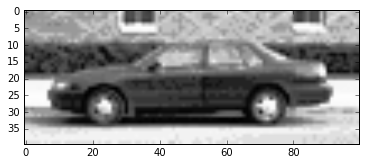

In [9]:
im = imread('data/CarData/TrainImages/pos-0.pgm')
plt.imshow(im, 'gray')
print im.shape

#### Primer negativnog uzorka - nije automobil

(40L, 100L)


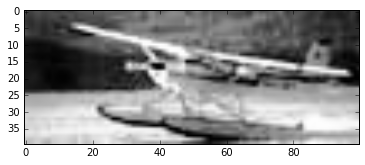

In [10]:
im = imread('data/CarData/TrainImages/neg-0.pgm')
plt.imshow(im, 'gray')
print im.shape

#### Učitavanje svih slika (pozitivnih i negativnih primera) sa diska.

In [11]:
train_dir = 'data/CarData/TrainImages/'

pos_imgs = []
neg_imgs = []
for img_name in os.listdir(train_dir):
    img_path = os.path.join(train_dir, img_name)
    img = imread(img_path)
    if 'pos' in img_name:
        pos_imgs.append(img)
    elif 'neg' in img_name:
        neg_imgs.append(img)
        
print 'positive images #:', len(pos_imgs), '| negative images #:', len(neg_imgs)

positive images #: 550 | negative images #: 500


#### Izračunavanje HOG deskriptora za sve slike i formiranje niza labela (1 = jeste automobil, klasa 0 = nije automobil)

In [12]:
from skimage.feature import hog  # importovanje implementacija HOG

In [17]:
pos_feats = []
neg_feats = []
labels = []

for img in pos_imgs:
    pos_feats.append(hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)))
    labels.append(1)
    
for img in neg_imgs:
    neg_feats.append(hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)))
    labels.append(0)
    
pos_feats = np.array(pos_feats)
neg_feats = np.array(neg_feats)
x = np.vstack((pos_feats, neg_feats))
y = np.array(labels)

### Obučavanje SVM za klasifikaciju HOG deskriptora

In [18]:
from sklearn.svm import SVC  # importovanje SVM klasifikatora

In [19]:
clf = SVC(kernel='linear')  # instanciranje linearnog SVM klasifikatora (ne koristimo kernel)
clf = clf.fit(x, y)
y_pred = clf.predict(x)

In [20]:
from sklearn.metrics import accuracy_score
print 'Acc:', accuracy_score(y, y_pred)

Acc: 0.994285714286


Vidimo da nakon obučavanja naš SVM klasifikator ima tačnost preko 99%... Super!
**Međutim**, velika je greška što smo i obučavali i validirali sa istim podacima, jer je moguće da je naš klasifikator overfitovao, a da toga nismo ni svesni!

**Dakle, neophodno je podeliti podatke na obučavajući (train) i testni (test) skup.**

In [21]:
from sklearn.cross_validation import train_test_split  # scikit-learn pomocna metoda za deljenje podataka na train/test set.

In [22]:
# parametar test_size je procenat koliko cemo podataka uzeti za testni skup
# naravno onda je procenat obucavajuceg skupa 1-test_size
# random_state parametar je random seed da se x i y izmesaju... da li neko zna zasto bas 42? :))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print 'Train shape:', x_train.shape, y_train.shape, ', Test shape:', x_test.shape, y_test.shape

Train shape: (840L, 2430L) (840L,) , Test shape: (210L, 2430L) (210L,)


In [23]:
clf_svm = SVC(kernel='linear')  # instanciranje linearnog SVM klasifikatora (ne koristimo kernel)
clf_svm.fit(x_train, y_train)  # obučavanje SVM
y_train_pred = clf_svm.predict(x_train)
y_test_pred = clf_svm.predict(x_test)
print 'Train acc:', accuracy_score(y_train, y_train_pred), ', Test acc:', accuracy_score(y_test, y_test_pred)

Train acc: 0.994047619048 , Test acc: 0.990476190476


Sada vidimo da nam je tačnost nad obučavajućim skupom 99.4%, a nad testnim skupom čak 99%! Ovo je odličan rezultat, i dobar znak da naš SVM klasifikator nije overfitovao.

### Logistička regresija za klasifikaciju HOG deskriptora

Čisto da vidite ne mora da se koristi uvek samo SVM za ovaj problem. U suštini, moguće je koristiti bilo kakav klasifikator. Logistička regresija je doduše dosta jednostavniji model mašinskog učenja od SVM.

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
clf_lr = LogisticRegression()
clf_lr = clf_lr.fit(x_train, y_train)
y_train_pred = clf_lr.predict(x_train)
y_test_pred = clf_lr.predict(x_test)
print 'Train acc:', accuracy_score(y_train, y_train_pred), ', Test acc:', accuracy_score(y_test, y_test_pred)

Train acc: 0.985714285714 , Test acc: 0.980952380952


Korišćenjem obične logističke regresije, dobijamo tačnost oko 98%, što je i dalje odličan rezultat.

### KNN za klasifikaciju HOG deskriptora

Još jedan primer, ovaj put KNN...

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn = clf_knn.fit(x_train, y_train)
y_train_pred = clf_knn.predict(x_train)
y_test_pred = clf_knn.predict(x_test)
print 'Train acc:', accuracy_score(y_train, y_train_pred), ', Test acc:', accuracy_score(y_test, y_test_pred)

Train acc: 0.986904761905 , Test acc: 0.97619047619


Kao što vidite, i ovaj put, sa KNN klasifikatorom (K=10), smo dobili zadovoljavajuće rezultate, oko 97% tačnost.

#### Obratite pažnju da, za sva tri klasifikatora koja smo isprobali, uvek smo dobili dobre rezultate (97%+). Kako ovo možemo protumačiti?

Pa prosto, ispostavlja se da je HOG deskriptor vrlo dobar alat za izdvajanje osobina objekata sa slike, i izgleda da su te izdvojene osobine relevantne prilikom klasifikacije. Odnosno, te osobine na neki reprezentativni način predstavljaju određenu vrstu objekta, što mi onda lako možemo koristiti za automatizaciju klasifikacije nekim od algoritama mašinskog učenja.

## Zadaci

Dakle, sada imamo obučen SVM klasifikator koji vrlo precizno (~99%) može da predvidi da li je nešto automobil ili ne. Međutim, ovaj klasifikator radi isključivo na slikama koje su veličine kao u obučavajućem skupu (100x40). U folderu ```data/CarData/TestImages/``` su date slike koje su različitih veličina (dosta veće od 100x40) i na kojima se nalaze automobili. Potrebno je detektovati **gde** se nalazi automobil na slici.


#### Primer testne slike

(115L, 210L)


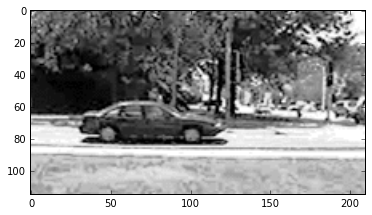

In [28]:
im = imread('data/CarData/TestImages/test-0.pgm')
plt.imshow(im, 'gray')
print im.shape

Tehnika kojom bi ovo trebalo raditi je pomoću tzv. klizećeg prozora (eng. sliding window), gde bi se na slici pomerao "prozor", veličine 100x40 i za svaki prozor se računao HOG deskriptor i zatim klasifikovao (da li je automobil ili ne). Zatim prozor pomerimo za, recimo 10 piksela u desno, i uradimo istu stvar. Naravno, kada dođemo do kraja reda, vratimo sliku skroz levo na početak i poerimo je za 10 piksela na dole, i tako dalje.

Ovim ćemo za sve moguće prozore (veličine 100x40 i sa pomerajima [10px, 0px], [0px, 10px]) dobiti rezultate klasifikacije.

![images/test-im-2.png](images/test-im-2.png)

Međutim, ovde nastaje problem - relativno je izvesno da ukoliko su unutar jednog prozora detektovali automobil, da ćemo i u nekom u susednih prozora detektovati isti taj automobil (prosto, translacijom za samo 10 piksela smo dobili vrlo sličnu sliku i samim tim vrlo sličan HOG deskriptor koji je ulaz u SVM klasifikator). Dakle, neophodno je na neki način spojiti više bounding box-ova u jedan koji će biti konačni rezultat. Vodite računa da među testnim slikama u ```data/CarData/TestImages/``` ima i slika na kojima se nalazi više od jednog automobila. Prilikom računjanja ovog konačnog bounding box-a, možete uzeti u obzir i koliko je SVM siguran (eng. confidence level) u svoju odluku za određeni ulazni podatak - ovu vrednost možete dobiti pozivanjem funkcije ```.decision_function(x)``` nad SVM klasifikatorom. Što je veća vrednost ove funkcije, SVM je "sigurniji" da je taj primer pozitivan (1, u našem slučaju da je automobil), a što je vrednost manja, SVM je sigurniji da taj primer negativan (0, u našem slučaju da nije automobil).

![images/test-im-2.png](images/test-im-2-nms.png)

Vaše konačne rezultate možete proveriti tako što ćete ih uporediti sa lokacijama automobila u datoteci ```data/CarData/trueLocations.txt```. U ovoj datoteci, svaka linija počinje sa rednim brojem slike iz foldera ```data/CarData/TestImages/```, a istinska lokacija automobila na slici je definisana koordinatama gornje-leve tačke bounding box-a (ovo je dato u datoteci), a širina i visina bounding box-a su *uvek* 100px i 40px, respektivno (kao veličina slika u obučavajućem skupu). Dakle, ako u datoteci imamo ```0: (48,26)```, to znači da je se na slici ```data/CarData/TestImages/test-0.pgm``` automobil nalazi na lokaciji koja je definisana bounding box-om ((48,26), (48+40,26+100)) = ((48,26), (88,126)). Ako se u datoteci nađe više koordinata u jednoj liniji, to znači da na toj slici ima više automobila.

Metrika kojom meriti poklapanje istinskog bounding box-a i vašeg predviđenog bounding box-a neka bude Jaccard index, odnosno IoU (intersection over union). Dakle, za dva bounding box-a, pronaći njihov presek i uniju, zatim prebrojati piksele u preseku u uniji i na kraju podeliti ova dva broja. $$ IoU = \frac{|A \cap B|}{|A \cup B|} $$

Ukoliko je poklapanje potpuno, vrednost IoU će biti 1, ako poklapanja nema biće 0, u slučaju delimičnog poklapanja biće neka vrednost između 0 i 1.

![images/iou_examples.png](images/iou_examples.png)

### Dodatno

Implementirati HOG+SVM detektor pešaka. Dataset na http://cbcl.mit.edu/software-datasets/PedestrianData.html.